# DiffusionEquation2D


### $$-div(k(x, y)\vec\nabla u(x, y)) + div(\vec v*u(x, y)) = f$$
### $$u|_{bound\_u} = u_0$$

1. У нас есть граница. Мы эту границу дискретизируем конечных набором точек.
2. У нас есть внутренность. Мы туда рандомно накидываем точки. По возможности равномерно, но в целом это пофигу.
3. Теперь используем диаграмму Воронова. Получаем клетки Дирихле.


произведем объемную апроксимацию.

$$
div(\vec{v}u) = \frac{1}{V_i}\int_{V_i}{div(\vec{v}u)dV} =
\frac{1}{V_i}\int_{\delta V_i}{\vec{v}u\vec{ds}} =\\
= \frac{1}{V_i}\sum_{j}{\int_{G_j}{u(\vec{v}\vec{n})ds}} =
\frac{1}{V_I}\sum_{j}{u_j(\vec{v}\vec{n_j})|G_i|}
$$

$$
div(k\vec\nabla u) = \frac{1}{V_i}\int_{V_i}{div(k\vec{\nabla}u)dV} =
\frac{1}{V_i}\int_{\delta V_i}{k(\vec{\nabla}u * \vec{ds})} =\\
= \frac{1}{V_i}\sum_{j}{k\int_{G_j}{(\vec{\nabla}u\vec{n})ds}} =
\frac{1}{V_I}\sum_{j}{u_j(\vec{v}\vec{n_j})|G_i|}
$$

In [4]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
import random
from scipy import interpolate

# 0 < x < 1
# 0 < y < 1

def real_u(x, y):
    return 1 + np.sin(x) * np.exp(-y)
def bound_u(x, y):
    if(x == 0):
        return 1
    if(x == 1):
        return 1 + np.sin(1) * np.exp(-y)
    if(y == 0):
        return 1 + np.sin(x)
    if(y == 1):
        return 1 + np.sin(x) * np.exp(-1)
    
def k(x, y):
    return x

def v(x, y):
    return 1
def f(x, y):
    return -np.sin(x) * np.exp(-y)

In [5]:
%matplotlib notebook

<IPython.core.display.Javascript object>


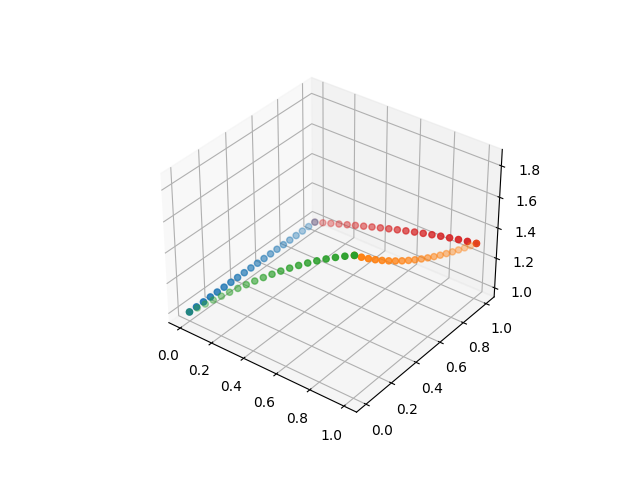

In [6]:
fig = plt.figure(10)
ax = plt.axes(projection='3d')
xx = [0 for i in np.linspace(0, 1, 20)]
yy = [j for j in np.linspace(0, 1, 20)]
zz = [bound_u(0, k) for k in np.linspace(0, 1, 20)]
ax.scatter3D(xx, yy, zz)

xx = [1 for i in np.linspace(0, 1, 20)]
yy = [j for j in np.linspace(0, 1, 20)]
zz = [bound_u(1, k) for k in np.linspace(0, 1, 20)]
ax.scatter3D(xx, yy, zz)

xx = [i for i in np.linspace(0, 1, 20)]
yy = [0 for j in np.linspace(0, 1, 20)]
zz = [bound_u(k, 0) for k in np.linspace(0, 1, 20)]
ax.scatter3D(xx, yy, zz)

xx = [i for i in np.linspace(0, 1, 20)]
yy = [1 for j in np.linspace(0, 1, 20)]
zz = [bound_u(k, 1) for k in np.linspace(0, 1, 20)]
ax.scatter3D(xx, yy, zz)

Метод конечных объемов на двумерной сетке с Пекле < 2

<IPython.core.display.Javascript object>


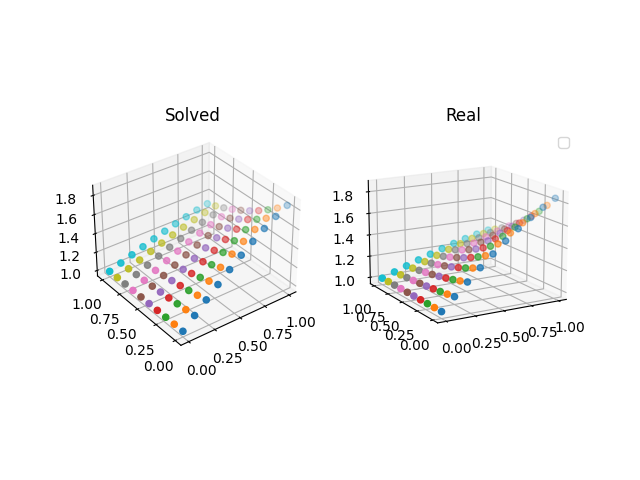

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<IPython.core.display.Javascript object>


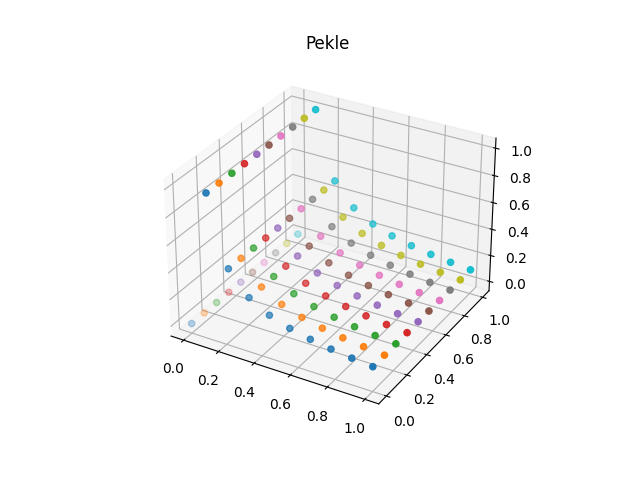

In [7]:
def finite_volumes_method_2D(x, y, bound_u, k, v, f, n):
    h_x = x[1] - x[0]
    h_y = y[1] - y[0]
    pekle = [[0]*n for i in range(n)]
    dots_amount = n*n
    
    M = [[0]*dots_amount for i in range(dots_amount)]
    for i in range(0, n):
        M[i][i] = 1
    for j in range(1, n-1):
        M[j*n][j*n] = 1
        for i in range (1, n-1):
            M[j*n+i][j*n+i] = k(h_x*(i-0.5), h_y*j)/(h_x**2) + \
                              k(h_x*(i+0.5), h_y*j)/(h_x**2) + \
                              k(h_x*i, h_y*(j-0.5))/(h_y**2) + \
                              k(h_x*i, h_y*(j+0.5))/(h_y**2) + \
                              (v(h_x*(i+0.5), h_y*j) - v(h_x*(i-0.5), h_y*j))/h_x + \
                              (v(h_x*i, h_y*(j+0.5)) - v(h_x*i, h_y*(j-0.5)))/h_y    #central                                   
            M[j*n+i][j*n+i-1] = -k(h_x*(i-0.5), h_y*j)/(h_x**2) - v(h_x*i, h_y*j)/(2*h_x) #left
            M[j*n+i][j*n+i+1] = -k(h_x*(i+0.5), h_y*j)/(h_x**2) + v(h_x*i, h_y*j)/(2*h_x) #right
            M[j*n+i][j*n+i-n] = -k(h_x*i, h_y*(j-0.5))/(h_y**2) - v(h_x*i, h_y*j)/(2*h_y) #down
            M[j*n+i][j*n+i+n] = -k(h_x*i, h_y*(j+0.5))/(h_y**2) + v(h_x*i, h_y*j)/(2*h_y) #up
        M[(j+1)*n-1][(j+1)*n-1] = 1
    for i in range(0, n):
        M[dots_amount - n + i][dots_amount - n + i] = 1
    
    
    F = [0]*dots_amount
    for i in range(n):
        F[i] = bound_u(h_x*i, 0)
    for j in range(1, n-1):
        F[j*n] = bound_u(0, h_y*j)
        for i in range (1, n-1):
            F[j*n+i] = f(h_x*i, h_y*j)
#         F[(j+1)*n-1] = bound_u(x[-1], h_y*j)
        F[(j+1)*n-1] = bound_u(1, h_y*j)
    for i in range(n):
        F[dots_amount - n + i] = bound_u(h_x*i, y[-1])

    matrix_solution = la.solve(M, F)
    
    result = [[0]*n for i in range(n)]
    for j in range(n):
        for i in range(n):
            result[j][i] = matrix_solution[j*n + i]
            
    for j in range(n):
        for i in range(n):
            if(k(h_x*i, h_y*j) != 0):
                pekle[j][i] = max(h_x, h_y) * v(h_x*i, h_y*j) / k(h_x*i, h_y*j)
            
    return result, pekle

n = 10
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)

solution, pekle = finite_volumes_method_2D(x, y, bound_u, k, v, f, n)

fig1 = plt.figure(1)


ax = fig1.add_subplot(121, projection='3d')
ax.set_title('Solved') 
for j in range(n):
    ax.scatter(x, [y[j]]*n, solution[j])

    
ax_real = fig1.add_subplot(122, projection='3d')
ax_real.set_title('Real')
z = [[0]*n for i in range(n)]
for i in range(n):
    for j in range(n):
        z[j][i] = real_u(x[i], y[j])
for j in range(n):
    ax_real.scatter(x, [y[j]]*n, z[j])
    
plt.grid()
plt.legend()

fig2 = plt.figure(2)
ax = fig2.add_subplot(111, projection='3d')
ax.set_title('Pekle') 
for j in range(n):
    ax.scatter(x, [y[j]]*n, pekle[j])

### Approximation

In [8]:
ns = [n for n in range(4, 10)]

hs = []
max_err = []
for n in ns:     
    xx = np.linspace(0, 1, n)
    yy = np.linspace(0, 1, n)
    hs.append(xx[1] - xx[0])
    solution, pekle = finite_volumes_method_2D(xx, yy, bound_u, k, v, f, n)
    err = []
    for i in range(len(xx)):
        err.append([0 for _ in range(len(xx))])
    #     print(real_sol)
        for j in range(len(yy)):
            err[i][j] = (real_u(xx[i], yy[j]) - solution[i][j])**2
    max_err.append(np.sum(err))

Approximation: -1.3565690183806542


<IPython.core.display.Javascript object>


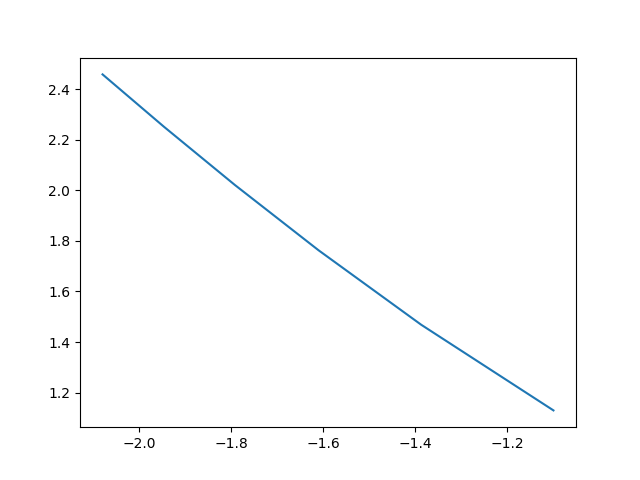

In [9]:
hs_log = np.log(hs)
max_err_log = np.log(max_err)
a, b = np.polyfit(hs_log, max_err_log, 1)
print("Approximation: {}".format(a))

fig15 = plt.figure(15)
plt.plot(hs_log, max_err_log)
# должен быть 1

Метод конечных объемов на двумерной сетке с оптимизированным k для Пекле < 2

In [128]:
def real_u(x, y):
    return x**2 + y**2
def bound_u(x, y):
    if(x == 0):
        return y**2
    if(x == 1):
        return 1 + y**2
    if(y == 0):
        return x**2
    if(y == 1):
        return 1 + x**2
def k(x, y):
    return x
def v(x, y):
    return 100 
def f(x, y):
    return -(2 * 2 * x + 2 * y + 2 * x) + 100 * (2 * x + 2 * y)

<IPython.core.display.Javascript object>


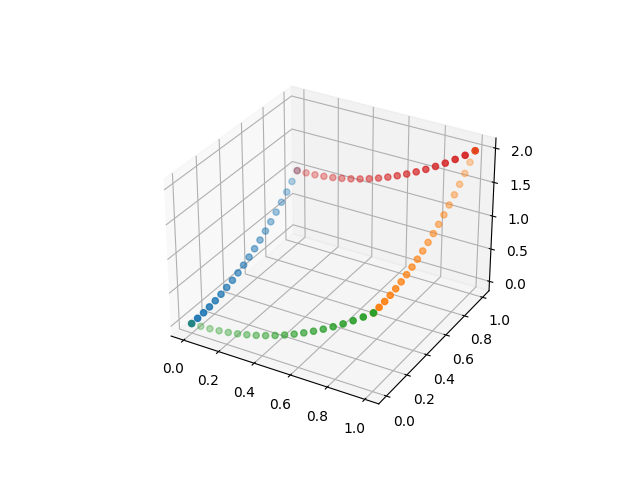

In [129]:
fig = plt.figure(11)
ax = plt.axes(projection='3d')
xx = [0 for i in np.linspace(0, 1, 20)]
yy = [j for j in np.linspace(0, 1, 20)]
zz = [bound_u(0, k) for k in np.linspace(0, 1, 20)]
ax.scatter3D(xx, yy, zz)

xx = [1 for i in np.linspace(0, 1, 20)]
yy = [j for j in np.linspace(0, 1, 20)]
zz = [bound_u(1, k) for k in np.linspace(0, 1, 20)]
ax.scatter3D(xx, yy, zz)

xx = [i for i in np.linspace(0, 1, 20)]
yy = [0 for j in np.linspace(0, 1, 20)]
zz = [bound_u(k, 0) for k in np.linspace(0, 1, 20)]
ax.scatter3D(xx, yy, zz)

xx = [i for i in np.linspace(0, 1, 20)]
yy = [1 for j in np.linspace(0, 1, 20)]
zz = [bound_u(k, 1) for k in np.linspace(0, 1, 20)]
ax.scatter3D(xx, yy, zz)

<IPython.core.display.Javascript object>


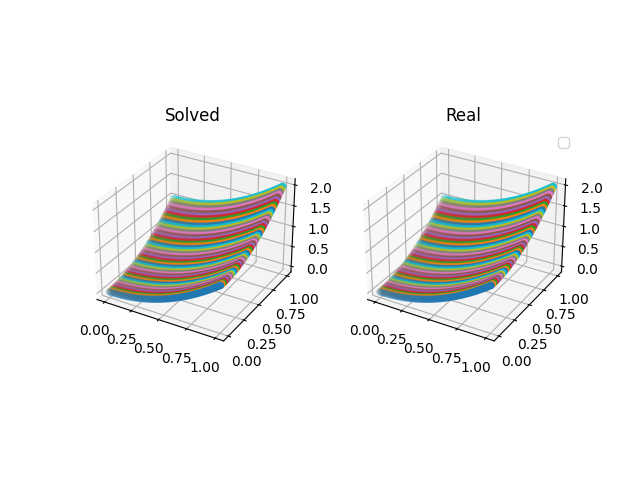

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<IPython.core.display.Javascript object>


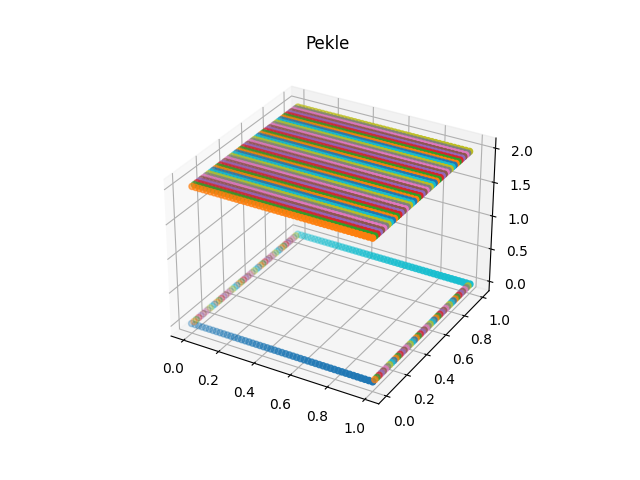

In [130]:
def finite_volumes_method_2D(x, y, bound_u, k, v, f, n):
    h_x = x[1] - x[0]
    h_y = y[1] - y[0]
    pekle = [[0]*n for i in range(n)]
    dots_amount = n*n
    a = 0.5
    def k_opt(x, y):
        p = a * ((max(h_x, h_y))*v(x, y))
        return p
    
    M = [[0]*dots_amount for i in range(dots_amount)]
    for i in range(0, n):
        M[i][i] = 1

    for j in range(1, n-1):
        M[j*n][j*n] = 1

        for i in range (1, n-1):
            if(max(h_x, h_y) * v(h_x*i, h_y*j) / k(h_x*i, h_y*j) < 2):
                M[j*n+i][j*n+i] = k(h_x*(i-0.5), h_y*j)/(h_x**2) + \
                                  k(h_x*(i+0.5), h_y*j)/(h_x**2) + \
                                  k(h_x*i, h_y*(j-0.5))/(h_y**2) + \
                                  k(h_x*i, h_y*(j+0.5))/(h_y**2) + \
                                  (v(h_x*(i+0.5), h_y*j) - v(h_x*(i-0.5), h_y*j))/h_x + \
                                  (v(h_x*i, h_y*(j+0.5)) - v(h_x*i, h_y*(j-0.5)))/h_y    #central                                   
                M[j*n+i][j*n+i-1] = -k(h_x*(i-0.5), h_y*j)/(h_x**2) - v(h_x*i, h_y*j)/(2*h_x) #left
                M[j*n+i][j*n+i+1] = -k(h_x*(i+0.5), h_y*j)/(h_x**2) + v(h_x*i, h_y*j)/(2*h_x) #right
                M[j*n+i][j*n+i-n] = -k(h_x*i, h_y*(j-0.5))/(h_y**2) - v(h_x*i, h_y*j)/(2*h_y) #down
                M[j*n+i][j*n+i+n] = -k(h_x*i, h_y*(j+0.5))/(h_y**2) + v(h_x*i, h_y*j)/(2*h_y) #up
                pekle[j][i] = max(h_x, h_y) * v(h_x*i, h_y*j) / k(h_x*i, h_y*j)
            else:
                M[j*n+i][j*n+i] = k_opt(h_x*(i-0.5), h_y*j)/(h_x**2) + \
                                  k_opt(h_x*(i+0.5), h_y*j)/(h_x**2) + \
                                  k_opt(h_x*i, h_y*(j-0.5))/(h_y**2) + \
                                  k_opt(h_x*i, h_y*(j+0.5))/(h_y**2) + \
                                  (v(h_x*(i+0.5), h_y*j) - v(h_x*(i-0.5), h_y*j))/h_x + \
                                  (v(h_x*i, h_y*(j+0.5)) - v(h_x*i, h_y*(j-0.5)))/h_y    #central                                   
                M[j*n+i][j*n+i-1] = -k_opt(h_x*(i-0.5), h_y*j)/(h_x**2) - v(h_x*i, h_y*j)/(2*h_x) #left
                M[j*n+i][j*n+i+1] = -k_opt(h_x*(i+0.5), h_y*j)/(h_x**2) + v(h_x*i, h_y*j)/(2*h_x) #right
                M[j*n+i][j*n+i-n] = -k_opt(h_x*i, h_y*(j-0.5))/(h_y**2) - v(h_x*i, h_y*j)/(2*h_y) #down
                M[j*n+i][j*n+i+n] = -k_opt(h_x*i, h_y*(j+0.5))/(h_y**2) + v(h_x*i, h_y*j)/(2*h_y) #up
                pekle[j][i] = max(h_x, h_y) * v(h_x*i, h_y*j) / k_opt(h_x*i, h_y*j)
        M[(j+1)*n-1][(j+1)*n-1] = 1
    for i in range(0, n):
        M[dots_amount - n + i][dots_amount - n + i] = 1
    
    F = [0]*dots_amount
    for i in range(n):
        F[i] = bound_u(h_x*i, 0)
    for j in range(1, n-1):
        F[j*n] = bound_u(0, h_y*j)
        for i in range (1, n-1):
            F[j*n+i] = f(h_x*i, h_y*j)
        F[(j+1)*n-1] = bound_u(x[-1], h_y*j)
    for i in range(n):
        F[dots_amount - n + i] = bound_u(h_x*i, y[-1])

    matrix_solution = la.solve(M, F)
    
    result = [[0]*n for i in range(n)]
    for j in range(n):
        for i in range(n):
            result[j][i] = matrix_solution[j*n + i]
            
#     for j in range(n):
#         for i in range(n):
#             if(k(h_x*i, h_y*j) != 0):
#                 pekle[j][i] = max(h_x, h_y) * v(h_x*i, h_y*j) / k(h_x*i, h_y*j)
            
    return result, pekle

n = 50
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)

solution, pekle = finite_volumes_method_2D(x, y, bound_u, k, v, f, n)

fig1 = plt.figure(3)
ax = fig1.add_subplot(121, projection='3d')
ax.set_title('Solved') 
for j in range(n):
    ax.scatter(x, [y[j]]*n, solution[j])
ax_real = fig1.add_subplot(122, projection='3d')
ax_real.set_title('Real')
z = [[0]*n for i in range(n)]
for i in range(n):
    for j in range(n):
        z[j][i] = real_u(x[i], y[j])
for j in range(n):
    ax_real.scatter(x, [y[j]]*n, z[j])
plt.grid()
plt.legend()

fig2 = plt.figure(4)
ax = fig2.add_subplot(111, projection='3d')
ax.set_title('Pekle') 
for j in range(n):
    ax.scatter(x, [y[j]]*n, pekle[j])

In [144]:
ns = [n for n in range(4, 20)]

hs = []
max_err = []
for n in ns:     
    xx = np.linspace(0, 1, n)
    yy = np.linspace(0, 1, n)
    hs.append(xx[1] - xx[0])
    solution, pekle = finite_volumes_method_2D(xx, yy, bound_u, k, v, f, n)
    err = []
    for i in range(len(xx)):
        err.append([0 for _ in range(len(xx))])
    #     print(real_sol)
        for j in range(len(yy)):
            err[i][j] = np.abs(real_u(xx[i], yy[j]) - solution[i][j])
    max_err.append(np.max(err))

Approximation: 0.9088304650032892


<IPython.core.display.Javascript object>


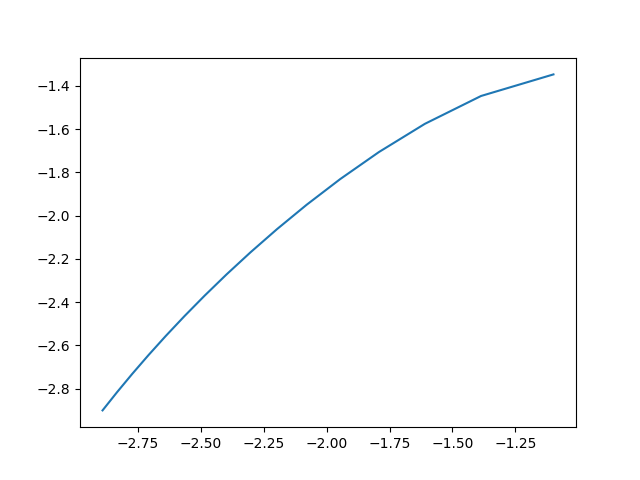

In [145]:
hs_log = np.log(hs)
max_err_log = np.log(max_err)
a, b = np.polyfit(hs_log, max_err_log, 1)
print("Approximation: {}".format(a))

fig15 = plt.figure(16)
plt.plot(hs_log, max_err_log)
# должен быть 1